In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.5 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from transformers import TFAutoModel, AutoTokenizer

# Load Data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/comments.csv',
                 usecols = ['rating', 'content'])
df.head()

,rating,content
0,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


# Data Preparation

In [8]:
print(f'Len of train dataset: {len(df)}')

Len of train dataset: 141281


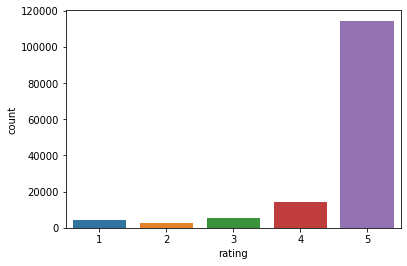

In [9]:
sns.countplot(x = df.rating);

### Missing Values

In [10]:
df.isna().sum()

rating         0
content    38018
dtype: int64

Let drop missing values!

In [11]:
df = df.dropna()

In [12]:
df.shape

(103263, 2)

### Split dataset

In [13]:
X = df.content.copy()
y = df.rating.copy()

# PhoBERT and XGBoost Classifier

## Tokenizer

In [14]:
X = df.content.copy()
y = df.rating.copy()

MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length', 
                    truncation = True, 
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X.items()]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(inputs), y,
                                                   random_state=1905, 
                                                   test_size=0.2, 
                                                   shuffle=True)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Label Encoder

In [15]:
# Encode labels from text to integers.
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(y_test)
test_labels_encoded = le.transform(y_test)

le.fit(y_train)
train_labels_encoded = le.transform(y_train)

In [16]:
PhoBERT_model = TFAutoModel.from_pretrained(model_name)

input_ids = Input(shape=(200,), dtype=tf.int32)

embedding = PhoBERT_model(input_ids)[1]

x = Dense(64, activation = 'gelu')(embedding)

feature_extractor = Model(inputs=[input_ids], outputs = x)

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [17]:
for layer in feature_extractor.layers:
	layer.trainable = False

In [18]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRoberta  TFBaseModelOutputWithPoo  134998272
 Model)                      lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [19]:
input_XGB = feature_extractor.predict(X_train)

2582/2582 [==============================] - 1063s 411ms/step


In [20]:
input_XGB.shape

(82610, 64)

In [21]:
X_for_training = input_XGB.copy()

## Base Model

In [22]:
# XGBOOST
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(X_for_training, y_train) # For sklearn no one hot encoding

XGBClassifier(objective='multi:softprob')

In [23]:
# Send test data through same feature extractor process
X_test_features = feature_extractor.predict(X_test)

# Now predict using the trained RF model. 
prediction = model.predict(X_test_features)

# Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

646/646 [==============================] - 267s 413ms/step
Accuracy =  0.7734469568585678


## Tuning Parameters

In [24]:
from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

param_grid = [
    {'subsample': [0.5], 'n_estimators': [1400, 1000], 
     'max_depth': [5, 4, 6], 'learning_rate': [0.02, 0.05],
     'colsample_bytree': [0.4], 'colsample_bylevel': [0.5],
     'reg_alpha':[1], 'reg_lambda': [1], 'min_child_weight':[2]}
]
grid = GridSearchCV(model, param_grid, 
													 cv=3, verbose=1, 
													 scoring='accuracy')

grid.fit(X_for_training, y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.8036920406091624
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 1400, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5}


In [25]:
# XGBOOST
import xgboost as xgb

tuned_model = xgb.XGBClassifier(**grid.best_params_)
# Tuned_model.set_params(**grid.best_params_)

tuned_model.fit(X_for_training, y_train) # For sklearn no one hot encoding

XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.4, learning_rate=0.05,
              max_depth=6, min_child_weight=2, n_estimators=1400,
              objective='multi:softprob', reg_alpha=1, subsample=0.5)

In [26]:
# Send test data through same feature extractor process
X_test_features = feature_extractor.predict(X_test)

# Now predict using the trained RF model. 
prediction = tuned_model.predict(X_test_features)

# Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

646/646 [==============================] - 267s 413ms/step
Accuracy =  0.8132958892170629
